# STGAT Model for Stock Price Prediction

This notebook combines all the necessary code from STGAT_train.py, STGAT.py, and get_data_rsr.py into a single Kaggle-compatible notebook.


In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# from test import window_size
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [50]:
# Configuration variables
dir = '/kaggle/input/your-data-folder'  # Adjust this path for your Kaggle setup
import os

num_companies = 150 # max is 1026
num_days = 1245
num_features = 5
window_size = 20 # if you change this is not changed everywhere yet unfortunately todo
calculate_correlation = False
train_batch = 1
val_batch = 1
K = 5
epochs = 20
val_min_num = 10
use_kfold = False

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle!")
    dir = '/kaggle/input/rsr-dataset/Data/'
    train_batch = 32
    val_batch = 32
    epochs = 100
    num_companies = 1026

else:
    dir = '/home/study/IdeaProjects/Graph-Machine-Learning/Temporal_RSR/data' # Samuel's directory
    print("Running locally!")
    # turn

SAVE_PREPROCESSED_DATA = False  # Set to True to save preprocessed data for faster loading


Running locally!


In [51]:
# Load data
print("train_batch", train_batch)
print("val_batch", val_batch)
print("epochs", epochs)
print("val_min_num", val_min_num)
print("K", K)

train_batch 1
val_batch 1
epochs 20
val_min_num 10
K 5


## 1. Install Required Packages


In [52]:
%pip install torch-geometric
%pip install statsmodels


Error processing line 1 of /home/study/anaconda3/envs/Graph-Machine-Learning/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 195, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Error processing line 1 of /home/study/anaconda3/envs/Graph-Machine-Learning/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 195, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to 

## 2. Import Libraries


In [53]:
import numpy as np
import torch
import torch.nn as nn
import random
import os
from torch_geometric.data import DataLoader, Data
import pandas as pd
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
import networkx as nx
import matplotlib.image as mpimg
from pathlib import Path
import torch.nn.functional as F
from statsmodels.tsa.seasonal import STL
from torch_geometric.nn import GATConv
from torch.utils.data import random_split
from sklearn.model_selection import KFold
import pickle

warnings.filterwarnings("ignore")


## 3. STGAT Model Classes (from STGAT.py)


In [54]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super(TemporalConv, self).__init__()
        padding = (0, kernel_size // 2)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=padding)
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=padding)
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=padding)

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = F.dropout(H, p=0.5, training=self.training)
        H = H.permute(0, 3, 2, 1)
        return H


In [55]:
class GAT(nn.Module):
    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        heads: int,
        num_layers: int
    ):
        super(GAT, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.heads = heads
        self.num_layers = num_layers
        self.conv_0 = GATConv(20, hidden_channels, heads=heads, concat=True, dropout=0.5, add_self_loops=True, edge_dim=1, fill_value=0, bias=True)
        self.bn_0 = nn.BatchNorm1d(hidden_channels * heads, eps=1e-5, momentum=0.1)

        self.layers = nn.ModuleList([
            GATConv(20 if i == 0 else hidden_channels * heads,
                    hidden_channels, heads=heads, concat=True,
                    dropout=0.5, add_self_loops=True, edge_dim=1)
            for i in range(num_layers)
        ])

        self.bns = nn.ModuleList([
            nn.BatchNorm1d(hidden_channels * heads)
            for i in range(num_layers)
        ])

        self.fc = nn.Linear(hidden_channels * heads, hidden_channels)
        self.activation = F.relu

    def forward(self, data, y):
        if y == 't': x = data.t
        elif y == 's': x = data.s

        edge_index = data.edge_index
        edge_weight = data.edge_weight

        x_0 = self.conv_0(x, edge_index, edge_weight)
        x_0 = self.bn_0(x_0)
        x_0 = self.activation(x_0)

        for i in range(self.num_layers - 1):
            x = self.layers[i](x, edge_index, edge_weight)
            x = self.bns[i](x)
            x = self.activation(x)
            x = F.dropout(x, 0.5, training=self.training)

        x = self.layers[self.num_layers-1](x, edge_index, edge_weight)
        x = x + x_0
        x = self.bns[self.num_layers-1](x)
        x = self.activation(x)
        x = self.fc(x)
        x = F.dropout(x, 0.5, training=self.training)

        return x


In [56]:
class GAT_TCN(nn.Module):
    def __init__(self,
                 num_nodes: int,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 heads: int = 3,
                 num_layers: int = 2,
                 kernel_size: int = 3
    ):
        super(GAT_TCN, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.heads = heads
        self.kernel_size = kernel_size

        self.tcn_1 = TemporalConv(in_channels, hidden_channels, kernel_size=kernel_size)
        self.tcn_2 = TemporalConv(hidden_channels, out_channels, kernel_size=kernel_size)
        self.gat_1 = GAT(num_nodes, 20, hidden_channels, out_channels, heads, num_layers)
        self.gat_2 = GAT(num_nodes, 20, hidden_channels, out_channels, heads, num_layers)

        self.linear_residual = nn.Linear(in_channels, hidden_channels)
        self.bn = nn.BatchNorm2d(num_nodes)
        self.fc = nn.Linear(self.num_nodes * (20 + 20), self.out_channels * 2048)
        self.fc1 = nn.Linear(2048, self.num_nodes)

    def forward(self, data) -> torch.FloatTensor:
        # Process residual data
        r = data.r
        r = r.reshape(-1, 20, self.num_nodes, self.in_channels)
        r = self.linear_residual(r)
        r = F.relu(r)
        r = F.dropout(r, 0.5, training=self.training)
        
        t = self.gat_1(data, 't')
        t = t.permute(1, 0).reshape(-1, 1, self.num_nodes, self.hidden_channels)
        s = self.gat_2(data, 's')
        s = s.permute(1, 0).reshape(-1, 1, self.num_nodes, self.hidden_channels)

        fused_features_list = []
        for t_idx in range(r.size(1)):
            r_t = r[:, t_idx, :, :]
            fused_t = r_t + t.squeeze(1)
            fusion = fused_t + s.squeeze(1)
            fused_features_list.append(fusion)

        fusions = torch.stack(fused_features_list, dim=1)

        x = data.x.reshape(-1, 20, self.num_nodes, self.in_channels)
        x = self.tcn_1(x)

        # Combine TCN and GAT outputs
        res = torch.cat((x, fusions), dim=1)
        res = self.tcn_2(res)

        res = res.permute(0, 2, 1, 3)
        res = self.bn(res)
        res = res.permute(0, 2, 1, 3)
        res = res.reshape(res.size(0), -1)

        # Final prediction layers
        res = F.relu(self.fc(res))
        res = self.fc1(res)

        return res


## 4. Data Loading Functions (from get_data_rsr.py)


In [57]:
def export_preprocessed_data(data_list, num_features, export_path="preprocessed_data.pkl"):
    """
    Export preprocessed data to disk for faster loading
    """
    export_data = {
        'data_list': data_list,
        'num_features': num_features,
        'metadata': {
            'num_samples': len(data_list),
            'num_companies': data_list[0].num_nodes if data_list else 0,
            'window_size': data_list[0].x.shape[1] if data_list else 0
        }
    }
    
    with open(export_path, 'wb') as f:
        pickle.dump(export_data, f)
    
    print(f"Preprocessed data exported to {export_path}")
    print(f"Exported {len(data_list)} samples with {num_features} features")

def load_preprocessed_data(export_path="preprocessed_data.pkl"):
    """
    Load preprocessed data from disk
    """
    if not os.path.exists(export_path):
        print(f"No preprocessed data found at {export_path}")
        return None
    
    try:
        with open(export_path, 'rb') as f:
            export_data = pickle.load(f)
        
        data_list = export_data['data_list']
        num_features = export_data['num_features']
        metadata = export_data.get('metadata', {})
        
        print(f"Loaded preprocessed data from {export_path}")
        print(f"Loaded {len(data_list)} samples with {num_features} features")
        print(f"Metadata: {metadata}")
        
        return data_list, num_features, 0, 0
        
    except Exception as e:
        print(f"Error loading preprocessed data: {e}")
        return None


In [58]:
def load_EOD_data(data_path, market_name, tickers, steps=1):
    """
    Load End-of-Day stock data
    """
    eod_data = []
    masks = []
    ground_truth = []
    base_price = []

    # Determine the expected number of rows based on the first ticker's data
    first_ticker_path = os.path.join(data_path, market_name + '_' + tickers[0] + '_1.csv')
    try:
        first_df = pd.read_csv(first_ticker_path, header=None)
        num_days = first_df.shape[0] - (1 if market_name == 'NASDAQ' else 0)
        num_features = first_df.shape[1] - 1
    except Exception as e:
        print(f"Error reading first ticker file {first_ticker_path}: {e}")
        return None, None, None, None

    eod_data = np.zeros([len(tickers), num_days, num_features], dtype=np.float32)
    masks = np.ones([len(tickers), num_days], dtype=np.float32)
    ground_truth = np.zeros([len(tickers), num_days], dtype=np.float32)
    base_price = np.zeros([len(tickers), num_days], dtype=np.float32)

    for index, ticker in enumerate(tickers):
        if index % 50 == 0:
            print(f"Processed [{index}/{tickers.shape[0]}] tickers")
        single_EOD_path = os.path.join(data_path, market_name + '_' + ticker + '_1.csv')

        try:
            single_df = pd.read_csv(single_EOD_path, header=None)
            if market_name == 'NASDAQ':
                single_df = single_df[:-1]

            # Handle missing values (-1234)
            single_EOD = single_df.values
            mask_row_indices, mask_col_indices = np.where(np.abs(single_EOD + 1234) < 1e-8)
            single_EOD[mask_row_indices, mask_col_indices] = 1.1

            # Update masks based on missing closing price
            missing_close_indices = np.where(np.abs(single_EOD[:, -1] + 1234) < 1e-8)[0]
            masks[index, missing_close_indices] = 0.0

            eod_data[index, :, :] = single_EOD[:, 1:]
            base_price[index, :] = single_EOD[:, -1]

        except Exception as e:
            print(f"Error reading ticker file {single_EOD_path}: {e}")
            masks[index, :] = 0.0

    print('eod data shape:', eod_data.shape)
    return eod_data, masks, ground_truth, base_price

def load_relation_data(relation_file):
    """
    Load relation data between companies
    """
    relation_encoding = np.load(relation_file)
    print('relation encoding shape:', relation_encoding.shape)
    rel_shape = [relation_encoding.shape[0], relation_encoding.shape[1]]
    mask_flags = np.equal(np.zeros(rel_shape, dtype=int),
                          np.sum(relation_encoding, axis=2))
    mask = np.where(mask_flags, np.ones(rel_shape) * -1e9, np.zeros(rel_shape))
    return relation_encoding, mask


In [59]:
def build_adjacency_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device):
    """
    Build normalized adjacency matrix from relation encodings and masks
    """
    # Combine relation encodings by summing across relation types
    industry_adj = torch.sum(industry_encodings, dim=-1)
    wiki_adj = torch.sum(wiki_encodings, dim=-1)

    # Combine both relation types
    combined_adj = industry_adj + wiki_adj

    # Apply masks: where mask is -1e9 (no relation), set adjacency to 0
    combined_mask = industry_mask + wiki_mask
    combined_adj = torch.where(combined_mask < -1e8, torch.zeros_like(combined_adj), combined_adj)

    # Normalize: row-wise normalization (each row sums to 1)
    row_sums = combined_adj.sum(dim=1, keepdim=True)
    adjacency_matrix = combined_adj / (row_sums + 1e-8)

    return adjacency_matrix.to(device)

def prepare_data(eod_data, masks, base_price, stl_data, device, window_size=20, prediction_horizon=1):
    """
    Create sliding windows for time series prediction with mask handling

    Args:
        eod_data: [num_companies, num_days, num_features]
        masks: [num_companies, num_days] - 1.0 for valid, 0.0 for missing
        base_price: [num_companies, num_days] - closing price of stock
        stl_data: dict with keys 'trend', 'seasonal', 'residual' containing [num_companies, num_days] arrays
        window_size: Number of historical days to use as input
        prediction_horizon: Number of days ahead to predict (usually 1)

    Returns:
        X: Input windows [num_samples, num_companies, window_size, num_features]
        y: Target returns [num_samples, num_companies, prediction_horizon]
        sample_masks: Valid sample indicators [num_samples, num_companies]
        t_features: Trend components [num_samples, num_companies, window_size]
        s_features: Seasonal components [num_samples, num_companies, window_size]
        r_features: Residual components [num_samples, num_companies, window_size]
    """
    num_companies, num_days, num_features = eod_data.shape
    num_samples = num_days - window_size - prediction_horizon + 1

    X = torch.zeros(num_samples, num_companies, window_size, num_features, device=device)
    y = torch.zeros(num_samples, num_companies, prediction_horizon, device=device)
    sample_masks = torch.zeros(num_samples, num_companies, device=device)
    
    # Initialize STL component arrays
    t_features = torch.zeros(num_samples, num_companies, window_size, device=device)
    s_features = torch.zeros(num_samples, num_companies, window_size, device=device)
    r_features = torch.zeros(num_samples, num_companies, window_size, device=device)

    for i in range(num_samples):
        X[i] = eod_data[:, i:i+window_size, :]
        y[i, :, 0] = base_price[:, i+window_size+prediction_horizon-1]
        
        # Extract STL components for this window
        t_features[i] = torch.tensor(stl_data['trend'][:, i:i+window_size], dtype=torch.float32, device=device)
        s_features[i] = torch.tensor(stl_data['seasonal'][:, i:i+window_size], dtype=torch.float32, device=device)
        r_features[i] = torch.tensor(stl_data['residual'][:, i:i+window_size], dtype=torch.float32, device=device)

        # A sample is valid if all days in the window AND the target day are valid
        window_valid = masks[:, i:i+window_size].min(dim=1)[0]
        target_valid = masks[:, i+window_size+prediction_horizon-1]
        sample_masks[i] = window_valid * target_valid

    return X, y, sample_masks, t_features, s_features, r_features

def adjacency_to_edges(adjacency_matrix):
    """Convert adjacency matrix to edge_index and edge_weight"""
    adj_np = adjacency_matrix.cpu().numpy()
    rows, cols = np.where(adj_np > 0)
    edge_weights = adj_np[rows, cols]
    edge_index = torch.tensor(np.stack([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(edge_weights, dtype=torch.float32).view(-1, 1)
    return edge_index, edge_weight


## 5. Main Data Loading Function


In [60]:
def get_data_rsr(export_path="preprocessed_data.pkl", force_reprocess=False):
    """
    Get RSR data, either by loading from disk or preprocessing from scratch
    """
    
    # Try to load preprocessed data first (unless force_reprocess is True)
    if not force_reprocess:
        preprocessed_data = load_preprocessed_data(export_path)
        if preprocessed_data is not None:
            return preprocessed_data
    
    print("Preprocessing data from scratch...")

    # Load relation data
    industry_encodings, industry_mask = load_relation_data(dir+'/relation/sector_industry/NASDAQ_industry_relation.npy')
    wiki_encodings, wiki_mask = load_relation_data(dir+'/relation/wikidata/NASDAQ_wiki_relation.npy')

    # Load company names
    tickers = np.loadtxt(dir+'/NASDAQ_tickers.csv', dtype=str)
    print('tickers shape (# of companies):', tickers.shape)

    # eod_data, eod_masks, eod_ground_truth, eod_base_price = load_EOD_data(dir+"/2013-01-01", "NASDAQ", tickers)

    # Use subset of data for the experiments
    n_companies = num_companies

    wiki_encodings = wiki_encodings[:n_companies, :n_companies, :]
    wiki_mask = wiki_mask[:n_companies, :n_companies]
    industry_encodings = industry_encodings[:n_companies, :n_companies, :]
    industry_mask = industry_mask[:n_companies, :n_companies]

    eod_data, eod_masks, eod_ground_truth, eod_base_price = load_EOD_data(dir+"/2013-01-01", "NASDAQ", tickers[:n_companies])
    
    # Pre-compute STL decomposition for complete time series per company
    print("Computing STL decomposition for complete time series...")
    
    # Extract complete time series for each company (all days) - closing prices
    complete_sequences = eod_data[:, :, -1]  # [num_companies, num_days] - close prices
    
    # Initialize arrays to store STL results for all companies
    num_days = complete_sequences.shape[1]
    complete_t_features = np.zeros((n_companies, num_days))
    complete_s_features = np.zeros((n_companies, num_days))
    complete_r_features = np.zeros((n_companies, num_days))

    from joblib import Parallel, delayed
    from tqdm import tqdm

    def stl_decompose(series, period=20):
        stl = STL(series, period=period, robust=True)
        result = stl.fit()
        return result.trend, result.seasonal, result.resid

    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(stl_decompose)(complete_sequences[i, :]) for i in tqdm(range(n_companies), desc="STL progress")
    )
    complete_t_features = np.stack([r[0] for r in results])
    complete_s_features = np.stack([r[1] for r in results])
    complete_r_features = np.stack([r[2] for r in results])

    # Apply STL to each company's complete time series
    # for company_idx in range(n_companies):
    #     if company_idx % 25 == 0:
    #         print(f"Processing STL for company {company_idx}/{n_companies}")
    #
    #     # Extract complete 1D time series for this company: [num_days]
    #     company_series = complete_sequences[company_idx, :]  # [num_days]
    #
    #     # Apply STL decomposition to complete time series
    #     stl = STL(company_series, period=20, robust=True)
    #     result = stl.fit()
    #
    #     # Store results for complete time series
    #     complete_t_features[company_idx] = result.trend
    #     complete_s_features[company_idx] = result.seasonal
    #     complete_r_features[company_idx] = result.resid
    
    print("STL decomposition completed.")
    
    # Create STL data dictionary
    stl_data = {
        'trend': complete_t_features,
        'seasonal': complete_s_features,
        'residual': complete_r_features
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    eod_data = torch.tensor(eod_data)
    masks = torch.tensor(eod_masks)
    price_prediction = torch.tensor(eod_base_price)

    # Relation data
    industry_encodings = torch.tensor(industry_encodings)
    industry_mask = torch.tensor(industry_mask)
    wiki_encodings = torch.tensor(wiki_encodings)
    wiki_mask = torch.tensor(wiki_mask)

    print(f"EOD data shape: {eod_data.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f"Ground truth shape: {price_prediction.shape}")
    print(f"Industry encodings shape: {industry_encodings.shape}")

    # Build adjacency matrix from relations
    adjacency_matrix = build_adjacency_matrix(
        industry_encodings, industry_mask,
        wiki_encodings, wiki_mask,
        device=device
    )
    print(f"Adjacency matrix shape: {adjacency_matrix.shape}")

    # Prepare temporal data with masks

    X_train, y_train, train_masks, t_train, s_train, r_train = prepare_data(
        eod_data, masks, price_prediction, stl_data,
        window_size=window_size,
        device=device,
        prediction_horizon=1
    )
    print(f"Training data: X={X_train.shape}, y={y_train.shape}, masks={train_masks.shape}")

    if not calculate_correlation:
        # Convert adjacency matrix to edge representation
        edge_index, edge_weight = adjacency_to_edges(adjacency_matrix)

    # Create list of Data objects for STGAT
    data_list = []
    num_samples = X_train.shape[0]

    # Create company ID mapping for tracking
    company_ids = list(range(n_companies))  # Company IDs: 0 to n_companies-1

    for i in range(num_samples):
        # Get sequence for this sample: [num_companies, window_size, num_features]
        sequence = X_train[i][:, :, -1:]  # [150, 20, 1] close price
        target = y_train[i]  # [150, 1] # todo check if correct y?
        mask = train_masks[i]  # [150]


        # If calculate_correlation on then calculate correlation between the stocks and use that as the graph
        if calculate_correlation:
            # todo check if this is correct
            if isinstance(sequence, torch.Tensor):
                sequence_np = sequence.squeeze(-1).cpu().detach().numpy()
            else:
                sequence_np = np.array(sequence).squeeze(-1) if sequence.ndim > 2 else sequence
            corr_matrix = np.corrcoef(sequence_np)
            sigmoid_corr = 1 / (1 + np.exp(-corr_matrix))
            alpha = 0.4
            adjacency_matrix = np.where(sigmoid_corr > alpha,
                                        sigmoid_corr,
                                        0)
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32, device=device)
            edge_index, edge_weight = adjacency_to_edges(adjacency_matrix)

        # todo do we want to remove self loops or not? okay probably keep them

        # Use pre-computed STL components
        t_features = t_train[i]  # [num_companies, window_size]
        s_features = s_train[i]  # [num_companies, window_size]
        r_features = r_train[i]  # [num_companies, window_size]

        # todo check this maybe closing price is not correct here
        x_features = sequence.squeeze(-1) # todo this should maybe not be s features

        # Create Data object
        data = Data(
            x=x_features.float(),
            t=t_features.float(),
            s=s_features.float(),
            r=r_features.float(),
            edge_index=edge_index.to(device),
            edge_weight=edge_weight.to(device),
            shouchujia=target.squeeze().float(),
            train_mask=mask
        )
        prediction_horizon = 1
        data.num_nodes = num_companies
        data.sample_idx = i  # Track which sample this is
        data.company_ids = torch.tensor(company_ids, dtype=torch.long)  # Track company IDs
        data.prediction_day = i + window_size + prediction_horizon - 1
        data_list.append(data)
        
        if i % 100 == 0:
            print(f"Created data sample {i}/{num_samples}")

    print(f"\nGenerated {len(data_list)} samples")
    print(f"First sample shapes:")
    print(f"  x: {data_list[0].x.shape}")
    print(f"  t: {data_list[0].t.shape}")
    print(f"  s: {data_list[0].s.shape}")
    print(f"  r: {data_list[0].r.shape}")
    print(f"  edge_index: {data_list[0].edge_index.shape}")
    print(f"  edge_weight: {data_list[0].edge_weight.shape}")
    print(f"  shouchujia: {data_list[0].shouchujia.shape}")

    # Export the preprocessed data for future use (if enabled)
    if SAVE_PREPROCESSED_DATA:
        export_preprocessed_data(data_list, num_features, export_path)

    return data_list, num_features, 0, 0


## 6. Training Functions (from STGAT_train.py)


In [61]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    total_loss = 0
    for step, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.shouchujia.reshape(-1, num_nodes)
        train_mask = data.train_mask.reshape(-1, num_nodes)
        loss = criterion(out, y)
        loss = loss * train_mask
        num_valid = train_mask.sum() + 1e-8
        loss = loss.sum() / num_valid

        loss.backward()
        optimizer.step()
        L1loss = criterion_2(out, y)
        L1loss = L1loss * train_mask
        L1loss = L1loss.sum() / num_valid
        total_loss += L1loss.item()
    return total_loss / len(train_loader)

def validate(model_xc):
    model_xc.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    all_company_ids = []
    all_sample_indices = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            y = data.shouchujia.reshape(-1, num_nodes)
            loss = criterion(out, y)
            train_mask = data.train_mask.reshape(-1, num_nodes)
            loss = loss * train_mask
            num_valid = train_mask.sum() + 1e-8
            loss = loss.sum() / num_valid
            L1loss = criterion_2(out, y)
            L1loss = L1loss * train_mask
            L1loss = L1loss.sum() / num_valid
            total_loss += L1loss.item()
            
            # Collect predictions, targets, and metadata
            all_predictions.extend(out.cpu().numpy().tolist())
            all_targets.extend(y.cpu().numpy().tolist())
            
            # Collect company IDs and sample indices for each prediction
            batch_size = out.shape[0]
            for batch_idx in range(batch_size):
                sample_idx = data.sample_idx[batch_idx].item() if hasattr(data, 'sample_idx') else 0
                company_ids = data.company_ids.cpu().numpy() if hasattr(data, 'company_ids') else list(range(num_nodes))
                
                for company_idx in range(num_nodes):
                    all_company_ids.append(company_ids[company_idx])
                    all_sample_indices.append(sample_idx)

    return total_loss / len(val_loader), all_predictions, all_targets, all_company_ids, all_sample_indices


## 7. Main Training Script


In [62]:
# Set random seed
fix_seed(50)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
Gdata_list, split, max_value, min_value = get_data_rsr()
first_sample = Gdata_list[0]
print("Data shapes:")
print("x:", first_sample.x.shape)
print("r:", first_sample.r.shape)
print("t:", first_sample.t.shape)
print("s:", first_sample.s.shape)
print("train_mask:", first_sample.train_mask.shape)

num_nodes = first_sample.t.shape[0]
in_channels = first_sample.r.shape[1]
print("Detected num_nodes:", num_nodes, "in_channels:", in_channels)


Using device: cuda:0
No preprocessed data found at preprocessed_data.pkl
Preprocessing data from scratch...
relation encoding shape: (1026, 1026, 97)
relation encoding shape: (1026, 1026, 43)
tickers shape (# of companies): (1026,)
Processed [0/150] tickers
Processed [50/150] tickers
Processed [100/150] tickers
eod data shape: (150, 1245, 5)
Computing STL decomposition for complete time series...


STL progress: 100%|██████████| 150/150 [00:00<00:00, 165.91it/s]


STL decomposition completed.
Using device: cuda
EOD data shape: torch.Size([150, 1245, 5])
Masks shape: torch.Size([150, 1245])
Ground truth shape: torch.Size([150, 1245])
Industry encodings shape: torch.Size([150, 150, 97])
Adjacency matrix shape: torch.Size([150, 150])
Training data: X=torch.Size([1225, 150, 20, 5]), y=torch.Size([1225, 150, 1]), masks=torch.Size([1225, 150])
Created data sample 0/1225
Created data sample 100/1225
Created data sample 200/1225
Created data sample 300/1225
Created data sample 400/1225
Created data sample 500/1225
Created data sample 600/1225
Created data sample 700/1225
Created data sample 800/1225
Created data sample 900/1225
Created data sample 1000/1225
Created data sample 1100/1225
Created data sample 1200/1225

Generated 1225 samples
First sample shapes:
  x: torch.Size([150, 20])
  t: torch.Size([150, 20])
  s: torch.Size([150, 20])
  r: torch.Size([150, 20])
  edge_index: torch.Size([2, 176])
  edge_weight: torch.Size([176, 1])
  shouchujia: tor

In [63]:
# Dataset preparation
data_set = Gdata_list
dataset_size = len(data_set)

# Dataset split
# train_ratio = 0.15
# train_size = 500
#
# val_test_ratio = 0.38
# train_size = int(dataset_size * train_ratio)
# val_size = int(train_size * val_test_ratio)
# train_dataset = data_set[:-val_size]
# val_dataset = data_set[-val_size:]
# test_dataset = val_dataset # todo change that this is not the same


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(dataset_size * train_ratio)
val_end = train_end + int(dataset_size * val_ratio)

train_dataset = data_set[:train_end]
val_dataset = data_set[train_end:val_end]
test_dataset = data_set[val_end:]

train_dataset_all = data_set[:val_end] # todo change this maybe to only be training

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

# Training parameters
if use_kfold:
    kf = KFold(n_splits=K, shuffle=False, random_state=None) # todo maybe set shuffle back to true
    fold_iter = enumerate(kf.split(train_dataset_all))
else:
    # train_idx = list(range(0,))
    # fold_iter = [(0, )]
    fold_iter = [(0, (
        range(len(train_dataset)),  # train indices
        range(len(train_dataset), len(train_dataset) + len(val_dataset)))  # val indices offset
    )]
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=K)

aggregate = 'cat'
lr = 1e-3
ours_weight_decay = 5e-3
weight_decay = 5e-3


in_size = 30
out_channels = 304

# Initialize model
gat = GAT_TCN(
    num_nodes=num_companies,
    in_channels=1,
    hidden_channels=128,
    out_channels=1,
    heads=3,
    num_layers=2,
    kernel_size=3
)

# Loss functions
criterion_2 = nn.L1Loss(reduction='none')
criterion = torch.nn.MSELoss(reduction='none')

# Training variables
val_predictions = []
val_targets = []
val_loss_list = []
train_loss_list = []

# Record best validation loss
best_val_loss = float('inf')
best_epoch = 0
best_model_state_dict = None


Train size: 857
Validation size: 183
Test size: 185


In [ ]:
# Cross-validation training
for fold, (train_idx, val_idx) in fold_iter:
    print(f'Fold {fold + 1}/{K}')
    # print(f'Train index: {train_idx}', f'Validation index: {val_idx}')

    train_subset = [train_dataset_all[i] for i in train_idx]
    val_subset = [train_dataset_all[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=train_batch, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=val_batch, shuffle=False)

    model = gat.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=7, verbose=True)

    for epoch in range(epochs):
        train_loss = train()
        val_loss, epoch_val_preds, epoch_val_targets, epoch_company_ids, epoch_sample_indices = validate(model)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        if epoch > val_min_num:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                best_model_state_dict = model.state_dict()
                val_predictions = epoch_val_preds
                val_targets = epoch_val_targets
                val_company_ids = epoch_company_ids
                val_sample_indices = epoch_sample_indices
            scheduler.step(val_loss)

        print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save best model
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, 'best_model_TGT_gat_tcn_A_fixed2.pt')

print(f'Best Test Loss: {best_val_loss:.4f}')


Fold 1/5
Epoch: 0, Training Loss: 0.1314, Validation Loss: 0.1391
Epoch: 1, Training Loss: 0.0812, Validation Loss: 0.2334
Epoch: 2, Training Loss: 0.0659, Validation Loss: 0.2405
Epoch: 3, Training Loss: 0.0644, Validation Loss: 0.2265


In [ ]:
# Save predictions to CSV with company tracking
val_df = pd.DataFrame({
    'Company_ID': val_company_ids,
    'Sample_Index': val_sample_indices,
    'Val_Predictions': [item for sublist in val_predictions for item in sublist],
    'Val_Targets': [item for sublist in val_targets for item in sublist]
})

val_df['Val_Predictions'] = val_df['Val_Predictions'].astype(float)
val_df['Val_Targets'] = val_df['Val_Targets'].astype(float)

# Save to CSV file
val_df.to_csv('prediction_gat_tcn_A_fixed2.csv', index=False, float_format='%.6f')
print("验证预测值和真实值已保存到CSV文件，包含公司ID和样本索引。")

# Display sample of the data for verification
print("\nSample of saved data:")
print(val_df.head(10))

# Plot training curves
train_loss_list = train_loss_list[val_min_num:]
val_loss_list = val_loss_list[val_min_num:]

episodes_train_list = list(range(len(train_loss_list)))
episodes_val_list = list(range(len(val_loss_list)))

plt.figure(figsize=(10, 6))
plt.plot(episodes_train_list, train_loss_list, label='train_loss_change', color='green')
plt.plot(episodes_val_list, val_loss_list, label='val_loss_change', color='red')
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


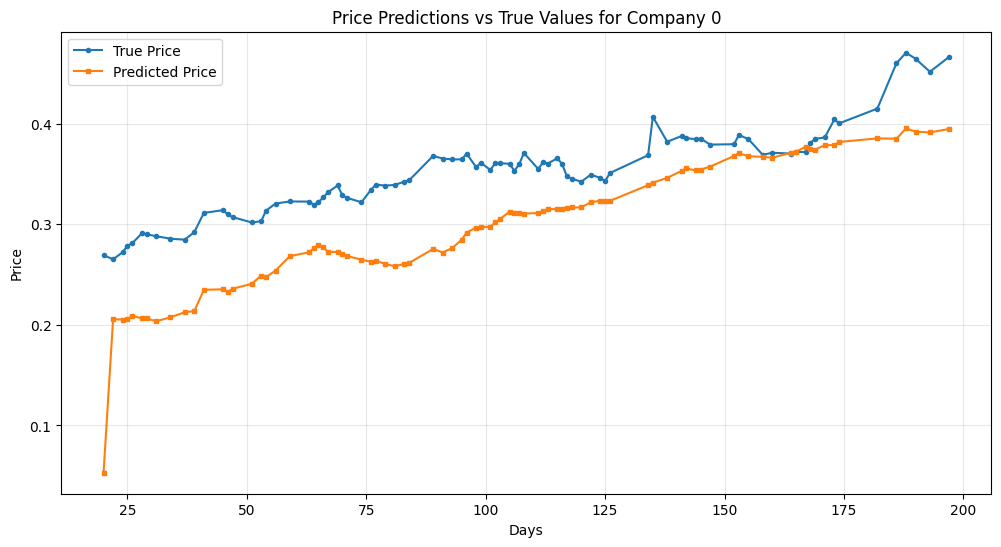

Company 0 Metrics:
  MSE: 0.003735
  MAE: 0.052967
  Number of samples: 88


In [43]:
# Example: Plot predictions vs targets for a specific company
def plot_company_predictions(company_id, df):
    """
    Plot predictions vs targets for a specific company over time
    """
    company_data = df[df['Company_ID'] == company_id].sort_values('Sample_Index')
    
    if len(company_data) == 0:
        print(f"No data found for company {company_id}")
        return
    
    plt.figure(figsize=(12, 6))
    # true_days = company_data['Sample_Index'] + window_size
    company_data['Day'] = company_data['Sample_Index'] + window_size
    company_data = company_data[company_data['Day'] <= 500]
    plt.plot(company_data['Day'], company_data['Val_Targets'],
             label='True Price', marker='o', markersize=3)
    plt.plot(company_data['Day'], company_data['Val_Predictions'],
             label='Predicted Price', marker='s', markersize=3)
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'Price Predictions vs True Values for Company {company_id}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate and display metrics
    mse = ((company_data['Val_Predictions'] - company_data['Val_Targets']) ** 2).mean()
    mae = abs(company_data['Val_Predictions'] - company_data['Val_Targets']).mean()
    
    print(f"Company {company_id} Metrics:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  Number of samples: {len(company_data)}")

# Example usage: Plot for company 0
plot_company_predictions(0, val_df)


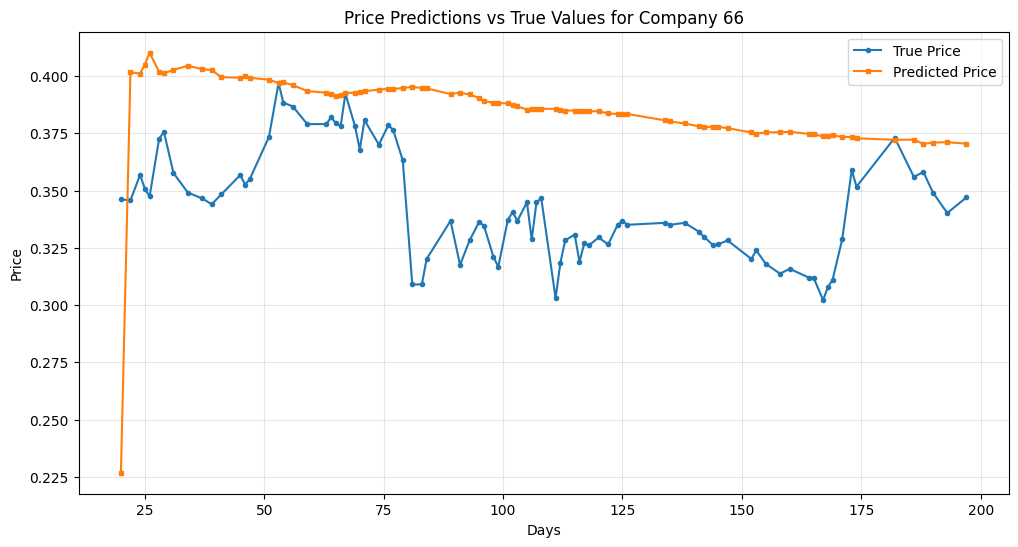

Company 66 Metrics:
  MSE: 0.002491
  MAE: 0.044633
  Number of samples: 88


In [44]:
plot_company_predictions(66, val_df)

In [ ]:
# Test Set Evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

# Load the best model
if best_model_state_dict is not None:
    model = gat.to(device)
    model.load_state_dict(best_model_state_dict)
    print("Loaded best model from training")
else:
    print("Warning: Using current model state (no best model saved)")

# Create test loader
test_loader = DataLoader(test_dataset, batch_size=val_batch, shuffle=False)

# Evaluate on test set
def test(model):
    model.eval()
    total_loss = 0
    total_mse = 0
    all_predictions = []
    all_targets = []
    all_company_ids = []
    all_sample_indices = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.shouchujia.reshape(-1, num_nodes)
            train_mask = data.train_mask.reshape(-1, num_nodes)

            # Calculate MSE loss
            mse_loss = criterion(out, y)
            mse_loss = mse_loss * train_mask
            num_valid = train_mask.sum() + 1e-8
            mse_loss = mse_loss.sum() / num_valid
            total_mse += mse_loss.item()

            # Calculate MAE loss
            mae_loss = criterion_2(out, y)
            mae_loss = mae_loss * train_mask
            mae_loss = mae_loss.sum() / num_valid
            total_loss += mae_loss.item()

            # Collect predictions, targets, and metadata
            all_predictions.extend(out.cpu().numpy().tolist())
            all_targets.extend(y.cpu().numpy().tolist())

            # Collect company IDs and sample indices
            batch_size = out.shape[0]
            for batch_idx in range(batch_size):
                sample_idx = data.sample_idx[batch_idx].item() if hasattr(data, 'sample_idx') else 0
                company_ids = data.company_ids.cpu().numpy() if hasattr(data, 'company_ids') else list(range(num_nodes))

                for company_idx in range(num_nodes):
                    all_company_ids.append(company_ids[company_idx])
                    all_sample_indices.append(sample_idx)

    avg_mae = total_loss / len(test_loader)
    avg_mse = total_mse / len(test_loader)

    return avg_mae, avg_mse, all_predictions, all_targets, all_company_ids, all_sample_indices

# Run test evaluation
test_mae, test_mse, test_predictions, test_targets, test_company_ids, test_sample_indices = test(model)

print(f'\nTest Set Results:')
print(f'  Test MAE: {test_mae:.6f}')
print(f'  Test MSE: {test_mse:.6f}')
print(f'  Test RMSE: {np.sqrt(test_mse):.6f}')

# Save test predictions to CSV
test_df = pd.DataFrame({
    'Company_ID': test_company_ids,
    'Sample_Index': test_sample_indices,
    'Test_Predictions': [item for sublist in test_predictions for item in sublist],
    'Test_Targets': [item for sublist in test_targets for item in sublist]
})

test_df['Test_Predictions'] = test_df['Test_Predictions'].astype(float)
test_df['Test_Targets'] = test_df['Test_Targets'].astype(float)

# Calculate additional metrics
test_df['Error'] = test_df['Test_Predictions'] - test_df['Test_Targets']
test_df['Absolute_Error'] = abs(test_df['Error'])
test_df['Squared_Error'] = test_df['Error'] ** 2

# Save to CSV
test_df.to_csv('test_predictions_gat_tcn_A_fixed2.csv', index=False, float_format='%.6f')
print("\nTest predictions saved to 'test_predictions_gat_tcn_A_fixed2.csv'")

# Display sample of test data
print("\nSample of test predictions:")
print(test_df.head(10))

# Calculate per-company metrics
print("\nPer-company test metrics (first 10 companies):")
for company_id in range(min(10, num_companies)):
    company_data = test_df[test_df['Company_ID'] == company_id]
    if len(company_data) > 0:
        company_mae = company_data['Absolute_Error'].mean()
        company_mse = company_data['Squared_Error'].mean()
        print(f"  Company {company_id}: MAE={company_mae:.6f}, RMSE={np.sqrt(company_mse):.6f}, Samples={len(company_data)}")

# Plot test predictions for a few companies
def plot_test_predictions(company_id, df, title_suffix=""):
    """Plot test predictions vs targets for a specific company"""
    company_data = df[df['Company_ID'] == company_id].sort_values('Sample_Index')

    if len(company_data) == 0:
        print(f"No data found for company {company_id}")
        return

    plt.figure(figsize=(12, 6))
    company_data['Day'] = company_data['Sample_Index'] + window_size

    plt.plot(company_data['Day'], company_data['Test_Targets'],
             label='True Price', marker='o', markersize=3, alpha=0.7)
    plt.plot(company_data['Day'], company_data['Test_Predictions'],
             label='Predicted Price', marker='s', markersize=3, alpha=0.7)

    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'Test Set: Price Predictions vs True Values for Company {company_id}{title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate metrics
    mse = company_data['Squared_Error'].mean()
    mae = company_data['Absolute_Error'].mean()

    print(f"Company {company_id} Test Metrics:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {np.sqrt(mse):.6f}")
    print(f"  Number of samples: {len(company_data)}")

# Plot test results for a few example companies
print("\nPlotting test predictions for example companies...")
plot_test_predictions(0, test_df)
plot_test_predictions(66, test_df)

# Compare validation vs test performance
print("\n" + "="*50)
print("VALIDATION vs TEST COMPARISON")
print("="*50)
print(f"Validation MAE: {best_val_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Difference: {abs(test_mae - best_val_loss):.6f}")

if test_mae > best_val_loss * 1.1:
    print("\n⚠️  Warning: Test loss is significantly higher than validation loss.")
    print("   This might indicate overfitting on the validation set.")
elif test_mae < best_val_loss * 0.9:
    print("\n✓ Test loss is better than validation loss.")
else:
    print("\n✓ Test and validation losses are similar - good generalization!")